
# Automatic Brain Tumor Detection and Segmentation 

## Using Tiramisu Layer

Mohammad Reza Tabrizi

Mohammad Reza Tabrizi

# Importar dados
### A seguinte função auxilia na importação dos dados recolhidos dos vários repositórios, associando a respetiva label aos mesmos. Os dados são convertidos em arrays:

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

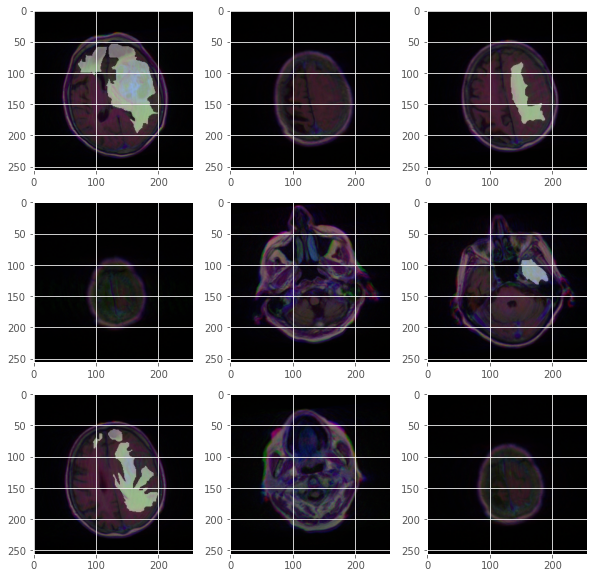

In [ ]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [ ]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})

In [ ]:
X_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [ ]:

for i in tqdm(range (len(df))):
    img_path=train_files[i]
    img=cv2.imread(img_path)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img
    msk_path=mask_files[i]
    mask_ =cv2.imread(msk_path)
    mask_ = rgb2gray(mask_)
    mask_.shape
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                              preserve_range=True), axis=-1)
    Y_train[i] = mask_

100%|██████████| 3929/3929 [00:44<00:00, 87.54it/s]


In [ ]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
print(X_train1.shape)
print(X_test1.shape)

(3536, 128, 128, 3)
(393, 128, 128, 3)


# Tiramisu

In [ ]:
def denseBlock(t, nb_layers):
    for _ in range(nb_layers):
        tmp = t
        t = BatchNormalization(axis=1,
                                gamma_regularizer=l2(0.0001),
                                beta_regularizer=l2(0.0001))(t)

        t = Activation('relu')(t)
        t = Conv2D(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
        t = Dropout(0.2)(t)
        t = concatenate([t, tmp])
    return t

def transitionDown(t, nb_features):
    t = BatchNormalization(axis=1,
                            gamma_regularizer=l2(0.0001),
                            beta_regularizer=l2(0.0001))(t)
    t = Activation('relu')(t)
    t = Conv2D(nb_features, kernel_size=(1, 1), padding='same', kernel_initializer='he_uniform',
               data_format='channels_last')(t)
    t = Dropout(0.2)(t)
    t = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_last')(t)
    return t

def Tiramisu(layer_per_block, n_pool=5, growth_rate=16):
    input_layer = Input(shape=(128, 128, 3))
    t = Conv2D(48, kernel_size=(3, 3), strides=(1, 1), padding='same')(input_layer)

    #dense block
    nb_features = 48
    skip_connections = []
    for i in range(n_pool):
        t = denseBlock(t, layer_per_block[i])
        skip_connections.append(t)
        nb_features += growth_rate * layer_per_block[i]
        t = transitionDown(t, nb_features)

    t = denseBlock(t, layer_per_block[n_pool]) # bottle neck

    skip_connections = skip_connections[::-1] #subvert the array

    for i in range(n_pool):
        keep_nb_features = growth_rate * layer_per_block[n_pool + i]
        t = Conv2DTranspose(keep_nb_features, strides=2, kernel_size=(3, 3), padding='same',
                            data_format='channels_last')(t) # transition Up
        t = concatenate([t, skip_connections[i]])

        t = denseBlock(t, layer_per_block[n_pool+i+1])

    t = Conv2D(1, kernel_size=(1, 1), padding='same', kernel_initializer='he_uniform', data_format='channels_last')(t)
    output_layer = Activation('sigmoid')(t)
    return Model(inputs=input_layer, outputs=output_layer)


layer_per_block = [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]



In [ ]:
tiramisu_sigmoid = Tiramisu(layer_per_block)


In [ ]:
tiramisu_sigmoid.summary()
tf.keras.utils.plot_model(tiramisu_sigmoid, "tiramisu_sigmoid.png", show_shapes = True)
tiramisu_sigmoid.compile(optimizer='adam', loss='binary_crossentropy',metrics=[iou])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 48) 1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 48) 512         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 48) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
nb_epoch = 50
batch_size = 8


In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('tiramisu_model.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]
history_tiramisu = tiramisu_sigmoid.fit(X_train1, y_train1,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    callbacks=callbacks,
                    verbose= 1,
                    validation_data= (X_test1,y_test1),
                    shuffle=False)

Epoch 1/50
442/442 [==============================] - 150s 229ms/step - loss: 0.5272 - iou: 0.1610 - val_loss: 0.2904 - val_iou: 0.1345
Epoch 2/50
442/442 [==============================] - 96s 218ms/step - loss: 0.1907 - iou: 0.2358 - val_loss: 0.1369 - val_iou: 0.1967
Epoch 3/50
442/442 [==============================] - 96s 218ms/step - loss: 0.1019 - iou: 0.2797 - val_loss: 0.1107 - val_iou: 0.1863
Epoch 4/50
442/442 [==============================] - 96s 218ms/step - loss: 0.0631 - iou: 0.3085 - val_loss: 0.1011 - val_iou: 0.1931
Epoch 5/50
442/442 [==============================] - 96s 217ms/step - loss: 0.0478 - iou: 0.3295 - val_loss: 0.0478 - val_iou: 0.2873
Epoch 6/50
442/442 [==============================] - 96s 217ms/step - loss: 0.0340 - iou: 0.3825 - val_loss: 0.0452 - val_iou: 0.3283
Epoch 7/50
442/442 [==============================] - 96s 217ms/step - loss: 0.0297 - iou: 0.4269 - val_loss: 0.0322 - val_iou: 0.3444
Epoch 8/50
442/442 [==============================] - 

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


<function matplotlib.pyplot.show>

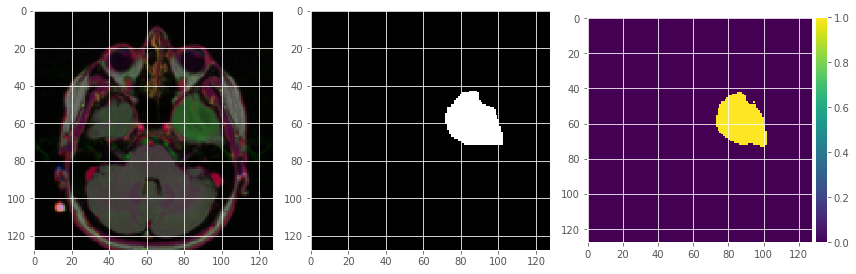

In [ ]:
preds_test_t = (y_pred_tiramisu_sigmoid > 0.5).astype(np.uint8)
# Perform a sanity check on some random trai ning samples
ix = random.randint(0, len(preds_test_t))
plt.figure(figsize=(12,6))
plt.subplot(131)
imshow(X_test1[ix])
plt.subplot(132)
imshow(np.squeeze(y_test1[ix]))
plt.subplot(133)
imshow(np.squeeze(preds_test_t[ix]))
plt.show

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


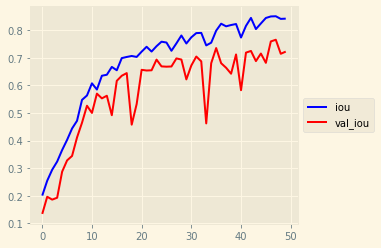

In [ ]:
with plt.style.context('Solarize_Light2'):
  plt.plot((history_tiramisu.history['iou']),label='iou', linestyle='-', color='b')
  plt.plot((history_tiramisu.history['val_iou']),label='val_iou', linestyle='-', color='r')
  ax = plt.subplot(111)
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


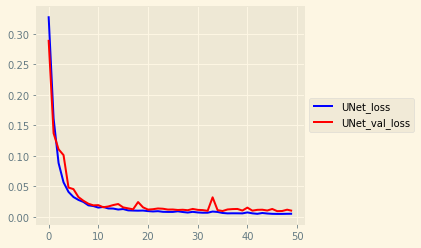

In [ ]:
with plt.style.context('Solarize_Light2'):
  plt.plot((history_tiramisu.history['loss']),label='UNet_loss', linestyle='-', color='b')
  plt.plot((history_tiramisu.history['val_loss']),label='UNet_val_loss', linestyle='-', color='r')
  ax = plt.subplot(111)
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.legend(loc='best')

plt.show()